## Description:
######Model type =LSTM
######Hidden layers = 32*2
######train seq_len = 200
######model id = rnn32-200, actually using lstm:(



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [4]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Data Loading

In [5]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 32
n_layers = 2
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "rnn32-200" #save as
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [7]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)
    
    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [12]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1, 32])
test cal_accuracy
0.015589999966323376
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
KD3ZKgKA333K33UKfj3ZSoDco EcoP3E33Pbbf33c:3P3E3K:PEU:3ZoKPfOcf3cD33P3TH$SOE3o KoP33UcO3EeDQ33EoKtaT3oZ3coP33KP3ZccPQo:fWOP3o:Zcf3g3c O:3p: HKtxUZe T:3KP3AO:3:3EUDKpc Pc33KoP3ocEeSOP3cPbf3ocE3cC3PcK33o
test generate with forwardc
Juliet333jZKK3jZH:cDOE3 cgfEWoc33 KpacZOgPbO3EU vg3 c:oEZcg3EWKj&ALQfpW&Zv:cg3 KK3EZKK3EZHKPcSw:fwPfKPcSDKPbKPbWbW&ZUDcDcDKr3E&jKKrhWc
DoPfZmcSDoPffEmH
TgA  

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 32]) torch.Size([2, 50, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1

Train

Build new model

In [13]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [17]:
train()

  0%|          | 0/432 [00:00<?, ?it/s, loss=3.395, test_ac=0.156, train_ac=0.150]


At 1 epoche, loss = 3.745, train ac = 0.116, test ac = 0.117
RNN write with seed Juliet

##############################

JulietdiletiV rasatribesoZoetzoyehuxi enu hodhtdtLahTet  sriadaetttFhrpfeatrosd lTrOteyo amha t
r  
a[rq3d  hruds i  $,cd h da lnrtgJ h maly
 yhhddb t  t n 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o                                                                                                                                                                                                       

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=3.249, test_ac=0.153, train_ac=0.154]


At 2 epoche, loss = 3.324, train ac = 0.153, test ac = 0.156
RNN write with seed Juliet

##############################

Juliets unew eu fm
rltt ,cemsoma ser  iont 
 u inshd,ii lab   eoio e   st

t untentshTf
ntp nP Aa
,utsodosleor ir so oeHslme
 srh  bhheh tiny

v ownwsv rs i

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
oo                                                                                                                                                                                                      

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=3.196, test_ac=0.167, train_ac=0.158]


At 3 epoche, loss = 3.236, train ac = 0.153, test ac = 0.156
RNN write with seed Juliet

##############################

Juliettssep rplyiwai,if eroane
ues uia  h   aofa   hi eee e hteo
eh
e tesooh ottw oh  s
ih ot h a t ish  e oe  mtono  i ft n ea
gnl 
d emtsatttabItp t  h dd

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
oo       

 
                                                                                                                   

                                                                      

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=3.077, test_ac=0.167, train_ac=0.170]


At 4 epoche, loss = 3.147, train ac = 0.162, test ac = 0.169
RNN write with seed Juliet

##############################

Julietfala baet i in  aoaeh yt huhh csirencli.situsd,stole toe aoe emo,edrs
 imespeerhi riea l irifhie oa t  nh oot the  ipsahoItrdnstn ur inaronten es ee
F

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:::o 

:::

                                                                              
                                    

                     e                       e                        

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.941, test_ac=0.210, train_ac=0.212]


At 5 epoche, loss = 3.024, train ac = 0.194, test ac = 0.201
RNN write with seed Juliet

##############################

Juliet sfsme  a hwcerli e iichbethincnhm neraas uDionfrass del-pol  enu ae uiesu ere der ioaa
T 
fdutoryfs tem eigs  auo ieu, hiiiari omsr
dlshg teru oe, fe

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:

o


:::

  eee   ee eee ee   e  ee e  eee  e   
  e ee e  e   e  e   eee   ee e        
ee e  e     ee  ee      e   ee ee  


e  eeee   e      e  ee  e ee    ee    
  e  ee   e    ee e   ee   eee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.833, test_ac=0.246, train_ac=0.235]


At 6 epoche, loss = 2.889, train ac = 0.219, test ac = 0.216
RNN write with seed Juliet

##############################

Julietpas pie dhe dh i
edau hhos cneoe tbafas hs sald lo.! whor -hup
oeiodnsn e eoan one a nor  tou, fme

Shleo uoiw kaus ped;sd san,

:or acwor al memn uyd

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:




::::

  ee    ee eee te   t  te e  teet t   
o e te ee e   e  tt  teet  teeee       
ee ttee     tet tete    tt  te tet 

oet eeeet  ttet   tt eet etee    eet   
  tt eet  t    ee eet eet  tee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.749, test_ac=0.264, train_ac=0.243]


At 7 epoche, loss = 2.778, train ac = 0.247, test ac = 0.249
RNN write with seed Juliet

##############################

Juliete
Fit bthe ot henet asf tholt ete swaol.

A;LOE:S
So fon 'es wead
Tetst,vn
As eei eit ar tas ir elt in urttirhf te uilr swas shercG ate in sod tahrhoc

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:
:I
:::::

  ter tete tee tet  tr tete  teet tr  
one te te e   tr tt  teet  tetee t t   
oe tnee  t  tet tete    tr  tettet 

oet teeetn tnetn  tt tet tnte t  tet   
  tt tete tr   te tet tet  tee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.664, test_ac=0.264, train_ac=0.262]


At 8 epoche, loss = 2.704, train ac = 0.254, test ac = 0.263
RNN write with seed Juliet

##############################

Juliet aaus etin til, I,

!A: AO fthen tee dis cot too

fo teu or nean chal sam, toun deolne ce noate sand tyte ololo

I eirmit

thas oals bogrerse tset Fol

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
::::I::::::

  ter tete tee ten  tr tone  toen tr  
one te te e   tr tn  toen  totee t t   
oe tnee  t  ten tene    tn  tenten 

oen teeenn tnenn  tn ten tnte t  ten   
  tn tone tnn  te ten ten  tee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.593, test_ac=0.282, train_ac=0.274]


At 9 epoche, loss = 2.637, train ac = 0.269, test ac = 0.272
RNN write with seed Juliet

##############################

Juliet nidp'l share molo boas,cu tik uo andurs yenue cerh col tseint no teehe lme hud de,do.

TNNUI:
I Ar add ot ttoahis thof whur whhe
Anl wes lhiget.
Uhog

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
::::I::::::

  tor tete toe tonn tn tone  toen tn  
one te te e   tn tn  toen  toree t t   
oe tnee  t  ten tone    tn  torten 

oen toeenn tnenn  In ton tnte t  tone  
  tn tone tnn  to ton tone toe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.565, test_ac=0.294, train_ac=0.277]


At 10 epoche, loss = 2.563, train ac = 0.285, test ac = 0.293
RNN write with seed Juliet

##############################

Juliet, bes trelees toel, I sous tat any hhe yho cavens ua want pasnave naatl yorsem phovor aran me noo aut on ir welafn
Fwe toe anln met sharithe tevee got

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:::I::::::

  tor tete the tonn tn tone  toen tn  
one to tote   tn tn  then  toree n t   
he tneer n  ten tone    tn  torten 

hen toeenn tnenn 
In ton tnte n  tone  
  tn tone tnn  to ton tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.560, test_ac=0.307, train_ac=0.293]


At 11 epoche, loss = 2.522, train ac = 0.292, test ac = 0.303
RNN write with seed Juliet

##############################

Juliet aln ine ime weu whis fand is, me the de, no fovhiw suke ylonr annd lanle, opisjent, ehe lheh nonot,
Wtha shome, yinf Ycease, Ar,
Wict.
Lard shate de 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
o:::I::::::
T  tor nete the tond tn tone  toen tn  
one te trte   tn tn  then  toree n n   
he tneer n  ten tone    tn  torten 

hen tohenn tnenn 
In ten tnte n  tone  
  tn tone tnn  te ton tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.470, test_ac=0.310, train_ac=0.309]


At 12 epoche, loss = 2.487, train ac = 0.304, test ac = 0.310
RNN write with seed Juliet

##############################

Juliet han barsthand he xo would wore pach ened site for rorilt mat carle feef sot lthe hine sere pos on lhol hold the sees th wols dot is.

DNIOAUSA:
Thoy 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
h:::I::::::
T  ter nete the tord tn tone  toen tn  
one te tnte   tn tn  then  toree n n   
he tneer n  ten tone    tn  torten 

hen tohenn tnenn 
In ten tnte n  tone  
  tn tone tnn  te trn tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.455, test_ac=0.323, train_ac=0.311]


At 13 epoche, loss = 2.459, train ac = 0.312, test ac = 0.317
RNN write with seed Juliet

##############################

Juliet the or wut luat tanbes the home car nor mime me wind in t hatt near soter se pemanf the Ro clocin piclure kein ald yhere for haf artloe fuky on us th

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
h:::IE:::::
T  ter nete the tord tn tone  toen tn  
one te tnte   tn tn  then  toree n n   
he tneer n  ten tone    tn  torton 

hen tohenn tnenn 
In ten tnteen  tone  
  tn tone tnn  te tnn tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.457, test_ac=0.333, train_ac=0.311]


At 14 epoche, loss = 2.444, train ac = 0.313, test ac = 0.327
RNN write with seed Juliet

##############################

Juliet?

AM: RH whe wons dome tile,
the me oul gas reeod citdo?

AI:
here thleun be serow thod hpewol wave poteas to non sinlacqyum revare yout mit on con k

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
h:::IE:::::
T  ter nete the tord tn tore  toen tn  
one te tntere tn tn  then  toreern nd  
he tneer n  ten tone    tnd toutot 

hen tohetn tnenn 
In ten tntoen  tonl  
  tn tone tnd  te tnn tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.400, test_ac=0.330, train_ac=0.327]


At 15 epoche, loss = 2.418, train ac = 0.320, test ac = 0.331
RNN write with seed Juliet

##############################

Juliet I me sofe thofe hare merp thamh,
Pboralrt Soud silit emeng dacres, fend to uundeet pemit tor mone thon feis thatritards in dauf mither sye soge hir. 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
h:::IE:::::
T  ter nete the tord tn tore  toen tn  
one te tntere tn tn  ther  toreern nd  
he tneer n  ten tone    tnd toutot 

her tohetn tnenn 
In ten tnteen  tonl  
  tn tone tn   te tnn tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.419, test_ac=0.340, train_ac=0.304]


At 16 epoche, loss = 2.413, train ac = 0.318, test ac = 0.336
RNN write with seed Juliet

##############################

Juliet waruftith, and a code ancarveis od ant anu noto; ir boy ou rag molodee
O hat enert hert,
Wan, me are lorle ens;;
oneriat me?

TRAIER:
As patanlut bet

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
h:::IE:::::
T  ter nete the tord tn tore  toet tn  
one te tntere tn tn  ther  threern nd  
he tneer nh ten tone r  tnd toutots

her tohetn tnenn 
In ten tntoetd tonl  
n tn tone tn   te tnn tone the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.333, test_ac=0.343, train_ac=0.327]


At 17 epoche, loss = 2.358, train ac = 0.330, test ac = 0.335
RNN write with seed Juliet

##############################

Juliet the om in wor ther in noll thal iR gould shaor weeet I hasred?

IOHTR:
Sinre
Ther of hory pogit hy ge bles.
Nen sive ge the rotath tanm-
Than, Trire 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tn tore  teet tn  
one te tntere tn tn  ther  threern nd  
he tneer nh tet tone r  tnd toutots

her toeetn tnenn 
In tet tntoetd tonl 

n tn tone tn   te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.317, test_ac=0.342, train_ac=0.336]


At 18 epoche, loss = 2.349, train ac = 0.333, test ac = 0.347
RNN write with seed Juliet

##############################

Juliet, rethir by wos os hen brere mougt erorens areds cmads:
Ater'r that thedas thout ir besered
Cancake, tin at? Thoud in ad hy hy than sint.

CRLEROH:
Co

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  teet tf  Tone te tntere tf tn  ther  three n nd  The tneer nh tet tone r  tnd toutots

her theetn tnenn 
In tet tntoetd torl 
Tn tn tone tf   te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.306, test_ac=0.357, train_ac=0.341]


At 19 epoche, loss = 2.328, train ac = 0.336, test ac = 0.347
RNN write with seed Juliet

##############################

Juliet in the worson were coult zaks mikan bonter b rother the hertpir!

AACERCO
RDG:
Anr more tale.

MSOILCAES:
Bot in thore wimir sart.

U IIEIB:
The me d

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  teet tf  Tone te tnteat tf tn  ther  three n nd  The tneer nh tet tone r  tnd thutots

her theetn tnhnn 
In tet tntoetd torl 
Tn tn tote tf   te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.309, test_ac=0.353, train_ac=0.339]


At 20 epoche, loss = 2.323, train ac = 0.343, test ac = 0.349
RNN write with seed Juliet

##############################

Juliet dand thou, the if deane thet
Horarthen thin cornt cinare lord andse nins as I buvy undes,
Where ltart me save thealt vay ly thir tasd
winuls potes, s

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  teet tf  Tone te tntoat tf tn  ther  three n nd  The tneer nh tet tonh r  tnd thutots

her theetn tnhnn 
In tet tntoetd torl 
Tn tn tote tf d te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.263, test_ac=0.354, train_ac=0.348]


At 21 epoche, loss = 2.316, train ac = 0.343, test ac = 0.354
RNN write with seed Juliet

##############################

Juliet ard fendy anll pice wild yor shace le war mosuco be, loaages sirch hile me worg atW thof thel's I the wil npace are hundinl the mere oo wines, once y

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  toet tf  Tone te tntoat tf tn  thet  three n nd  The tneer nh tet tonh r  tnd toutots

her theetn tnhrn 
In tet tntoetd torl 
Tn tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.304, test_ac=0.362, train_ac=0.336]


At 22 epoche, loss = 2.294, train ac = 0.351, test ac = 0.355
RNN write with seed Juliet

##############################

Julieter kind and in sillcor radtpall mousithange thor whas thou wich omilg of ant lors thith endet ratitame
In rir cod of fot then nise ams,
Unrdt.

VOSHUA

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  toet tf  Tone te tntoat tf tn  thet  threern nd  The tneer nh tet tonh r  tnd thutots

het theetn tnern  In tet tntoetd torl 
T  tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.267, test_ac=0.368, train_ac=0.349]


At 23 epoche, loss = 2.283, train ac = 0.349, test ac = 0.359
RNN write with seed Juliet

##############################

Julietod waull lour boitith to gheind im the you nomsels thas
hir iy cowr fhill she covet anlt't divewt ou'lgH gor thou bitere dame an I thinr,
Goud tirow t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  toet tf  Tone te tntoat tf tn  thet  threern nd  The tneer nh tet tonh r  tnd thutots

het theetn tnern  In tet tntoetd torl 
Tn tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.218, test_ac=0.363, train_ac=0.368]


At 24 epoche, loss = 2.253, train ac = 0.360, test ac = 0.366
RNN write with seed Juliet

##############################

Juliet bath in hers, dare this dir same, you wimes heelare mout be gerths the be sur.

A
RAOTO NEOS:
Welg! Thou

Nos oI of werius seace he, you grarde u the

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  ter nete the tord tf tore  toet tf  Tone te tntoat tf tn  thet  threern nd  The tneer nh tet tonh r  tnd thutots

het theetn tnern 
In tet tntoetd torl 
Tn tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.246, test_ac=0.367, train_ac=0.357]


At 25 epoche, loss = 2.227, train ac = 0.366, test ac = 0.365
RNN write with seed Juliet

##############################

Juliet he nond; I weie. Thile Ifor shich cime hen and wes ryanle gomargher wy to deelg sis of hens pot to gow anls.

PCRIRINE:
Memhere tham thant, hen lobom

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  tet nhte the tord tf tore  toet tf  Tone te tntoat tf tn  thet  threern nd  The tneer nh tet tonh r  tnd thutets

het theetn tnern 
In tet tnteetd torl 
T  tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.291, test_ac=0.376, train_ac=0.352]


At 26 epoche, loss = 2.233, train ac = 0.357, test ac = 0.373
RNN write with seed Juliet

##############################

Julieticounlires avolr you mrath the mave.

BALAATEN:
The the bins'rt fovy bind.

EULII:
Thundy.

EENTSORT:
Al thiwy thinpance wo haswind be daes hen of hin

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  tet nhte the tord tf tote  toet tf  Tote te tntoat tf tn  thet  thteern nd  The tneer nh tet tonh r  tnd th tots

het theetn tnhrn 
In tet tntoetd torl 
T  tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.260, test_ac=0.370, train_ac=0.359]


At 27 epoche, loss = 2.238, train ac = 0.359, test ac = 0.379
RNN write with seed Juliet

##############################

Julieth.

SONSANENT:
O bount so daven, ttile thy bard unthed was in sneed the hot not on heny bid me me preaot you seer nand herasse.

Wiatter ales no o lce

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  tettnhte the tord tf tote  toet tf  Tote te tntoat tf tn  thet  thteern nd  The tneer nh tet toth r  tnd th tets

het theetn tnhrn 
In tet tnteetd torl 
Tn tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.193, test_ac=0.375, train_ac=0.379]


At 28 epoche, loss = 2.226, train ac = 0.363, test ac = 0.375
RNN write with seed Juliet

##############################

Julieter to on ir a woth to mowh, on you if hereed vind
Wod lilurds, your glorge sery an thou bat the and fot the fem
As nosteed of with
As ligy and lited!


##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IR:::::
T  tettnhte the tord tf tote  toet tf  Tote te tnthat tf tn  thet  thteorn nd  The tneer nh tet toth r  tnd th tets

het theetn tnhrn 
In tet tnteetd torl 
T  tn tote tfdd te tnn tote the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.205, test_ac=0.390, train_ac=0.370]


At 29 epoche, loss = 2.227, train ac = 0.364, test ac = 0.377
RNN write with seed Juliet

##############################

Juliet,
The fims.

LOONN:
Bors and lote cace.

QANRO WELLSNU:
What so maaves,
Whet four and snout on hash to shore of wister in freang, waarle, meace hod og

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::IN:::::
T  tettnete the tord tf tote  toet tf  Tote te tnthat tf tn  thet  threorn nd  The tneer nh tet thth r  tnd th tets

het theetn tnhrn 
In tet tnteetd torl 
T  tn tote tfdd te tnn tote the 

##############################



100%|██████████| 432/432 [00:07<00:00, 57.54it/s, loss=2.222, test_ac=0.377, train_ac=0.367]



At 30 epoche, loss = 2.202, train ac = 0.370, test ac = 0.378
RNN write with seed Juliet

##############################

Juliether
To the be ghagh ald deethartek Ander houf, lord her and the thrie, cofe bere and oor fnom on wave bite, thaegh mour aunder the nir she und of dave

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
 :::EN:::::
T  tettnete the tord tf tote  toet tf  Tote te tnthat tf tn  thet  thteorn ng  The tneer nh tet thth d  tnd th tets

het theetn tnhrn 
In tet tnteetd torl 
T  tn tore tfdd te tnn tote the 

##############################

Tranning records saved to disk.


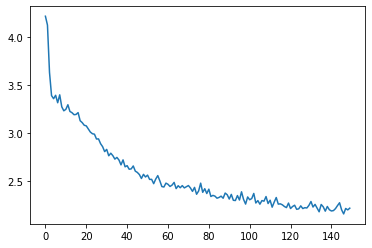

In [29]:
plt.figure()
plt.plot(record['loss'])
plt.show()

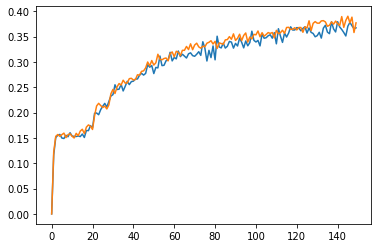

In [30]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [20]:
print(generate(model, device)) #default tau = 0.8

Juliet. The the loves the nath at in mill sibte mirs so none, and the slecpate,
And yeclateles were are colles,
In met, in mame, me thind erang the keasteat


In [21]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

juliet the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t 

julietrg,
Betranh, ic yu: Grurj't,t?, gery INts, SwoltbtM lh,iptpy Of.
B doodh,
Culdc Reut'ss-Gfwave
Aflit Kasnost: Ipabilsory.D

ZBGIAH:
Ser:-
Tthraulp. ba 



In [22]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i will,
He te diston cind the veanger thou than the tese thar heas fothss I mite, shir acow this hattt the the xinlone a wing lithrreit you the hir Peat, huen luvess thou peand
To the cuce not as wepion piseind sreall nouth in som, they you the fiy arloines hat flous thad bite hassitt and what nod: to thaes mint thy im och lord; ponelr!
Non
healr, the hrother:
The hes ou't do prether with fid abere to thou cether the she delaast of the wam theas dome boursent cevere!
There with they at pist be couthel 



In [23]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.3790856897830963

In [24]:
calc_accuracy(model, train_data, n_batch=len(test_data)-1, device=device)

0.38567617535591125

In [25]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
 n   tothne  
Torere tirtoete d tnd torth r  te r te thean 

ARE 
Toerr  theat 

AAnst tolhne  
Tou tne tnl teatnder teth r th tetsthet th torene 

ARE 
Tor reer 
Ieatneer 

AAnst tolhne  
Ton    tou 


In [26]:
random_train_seq(model, nptext, seq_len=seq_len, device=device, random=True)

----------input data----------
 is no matter.

NYM:
Slice, I say! pauca, pauca: slice! that's my humour.

SLENDER:
Where's Simple, my man? Can you tell, cousin?

SIR HUGH EVANS:
Peace, I pray you. Now let us understand. There is
th
----------prediction----------
tn tottether 

AAAR
Toete  t tht  Iorlht torlhn thete 
Ihet s te tet nr 

AAAREES:
There s tot ee  te tetd
Iotdtou thrl  torrtnd

AANNIERE IRIN::
Toane  t toet tou 
Ior toa tn tnder   nd 
The e tn Ihe


In [27]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i willd;
I wom wis od thin grekes to dourn marter moude; bat bind nom ank, hit his the he this to with in whorth mood terame? the wal wach ath maul gleirisy the sour waciing wryire:
And our stile the dore to whas the foon on condomind mave hecpand thal thar mall,
Hake is won:
So me in ssoud the, saestofe: I and mind in thy me me shy the hand of, the me hore.

BAOAUCAUTNN:
When fiy thar reads, the winsime, for leand the mapind, of of not gout she-ka, I arpen
Sheave to wind sterind the mate of nemle.

R 



In [28]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #honours

i will sore pilred ferele bas he spovirt,
That bord the for here, nos an: bance me ry and and thou ctor muthis that il thar paloses not anlg,
Mony be this and shat of tary mow?

SOENLE:
Waed po tret dould me coves and me lich won thou emy gods, thou done thou thingand coensd.

TASENRETE:
The sather there;
basees-finp; whturd, hers;
Cead pray, not cebind, I she selpaty bill be qoum yues of the his a no thou the wingt thou be, wad and hind be mere briprodt mas I tumer mish she beser the vert heas me: ba 

